In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=2, suppress=False)

cuda:0


# Data processing

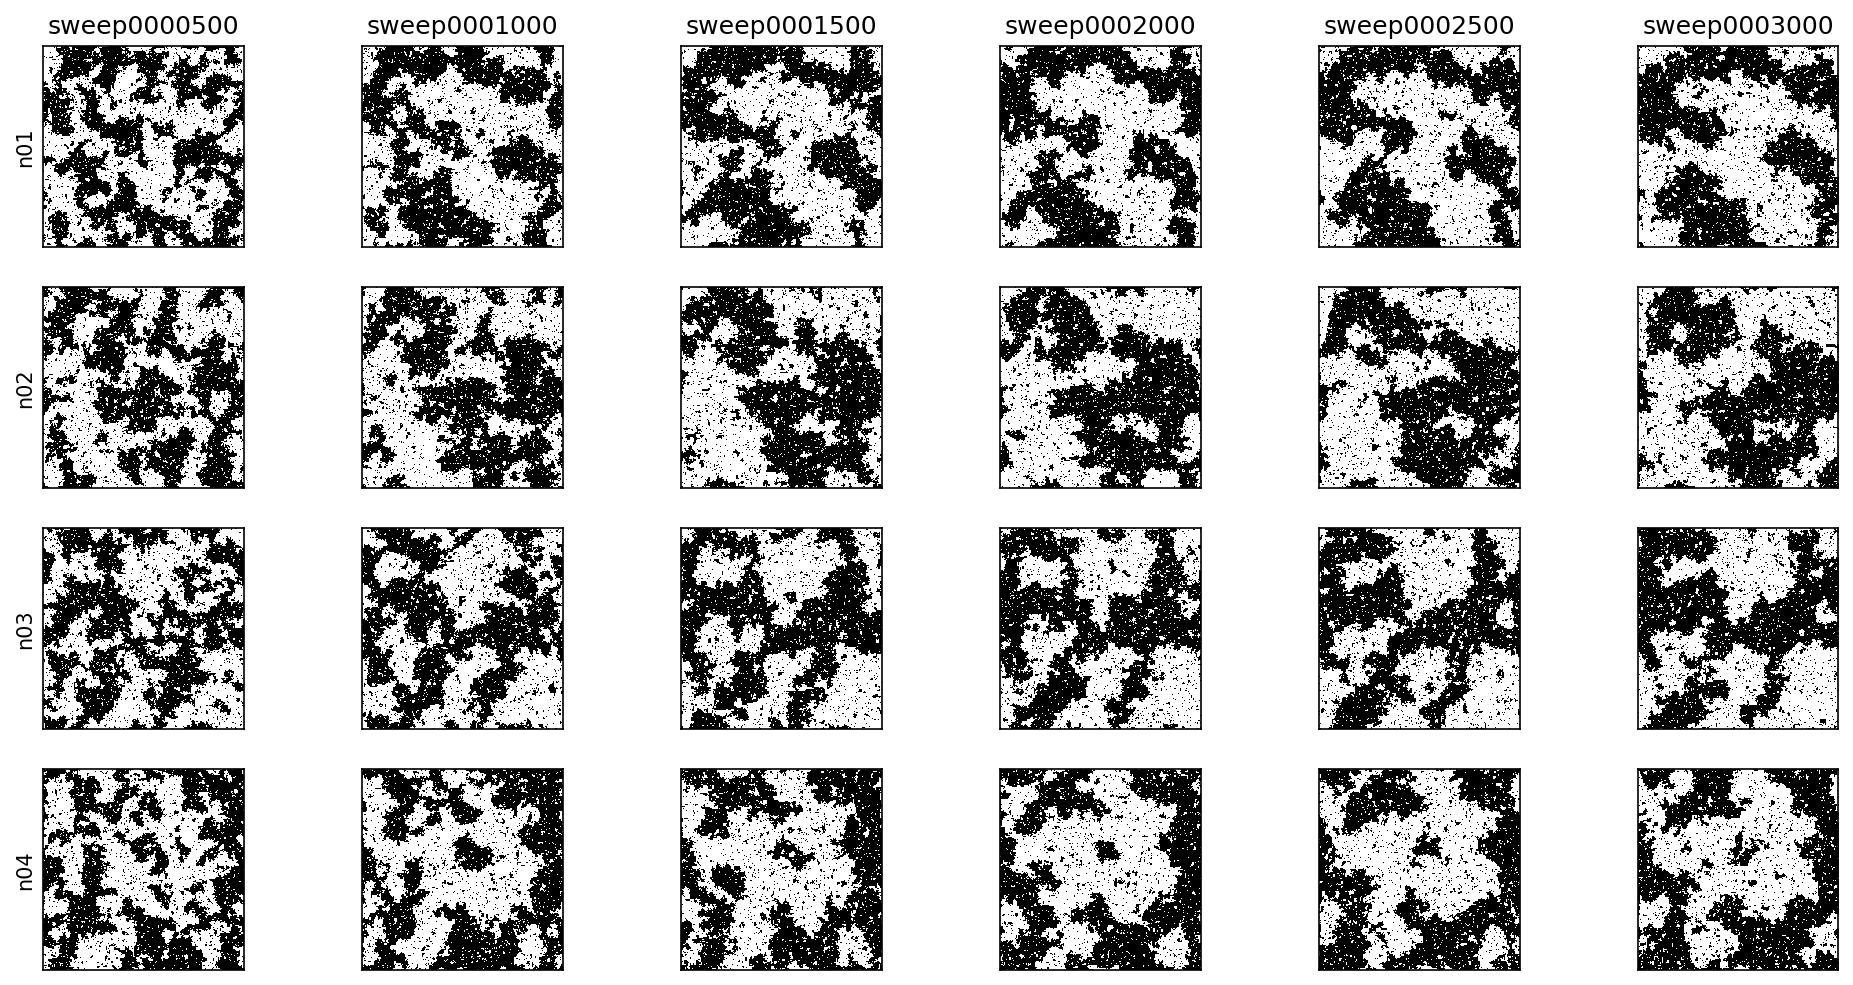

In [2]:
from tqdm import tqdm
from glob import glob
import json
import os

data_dir = '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data'
folders = sorted(glob(f'{data_dir}/n*'))

fig, ax = plt.subplots(4,6, dpi=150, figsize=(16,8))

for i in range(4):
    data_files = sorted(glob(f'{folders[i]}/sweep*.npy'))
    for j in range(6):
        frame_num = j + 1
        data = np.load(data_files[frame_num], mmap_mode='r')
        ax[i,j].imshow(data, cmap='Greys', interpolation='None', vmin=-1, vmax=1)
        ax[i,j].set(xticks=[], yticks=[])
        
        ax[0,j].set_title(os.path.basename(data_files[frame_num])[:-4])
    ax[i,0].set_ylabel(os.path.basename(folders[i]))

193
x (256, 256)
y (256, 256)
dt 1
t (5,)
phi torch.Size([5, 1, 256, 256])


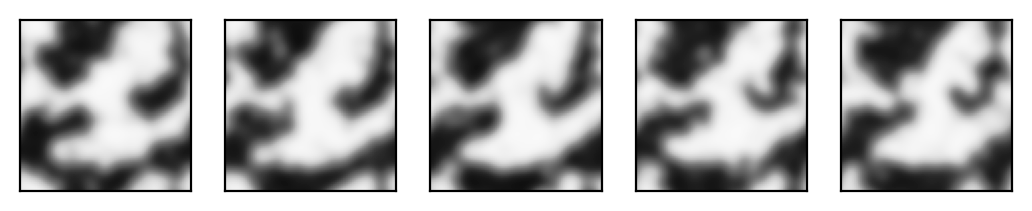

In [3]:
from forecasting_dataset import SimulationDataset

ds = SimulationDataset(f'{data_dir}/n01', sigma=10)
print(len(ds))

sample = ds[5]
for key in sample:
    try:
        print(key, sample[key].shape)
    except:
        print(key, sample[key])

fig, ax = plt.subplots(1, len(sample['t']), dpi=200)

for i in range(len(ax)):
    ax[i].pcolormesh(sample['x'], sample['y'], sample['phi'][i].squeeze(), cmap='Greys', vmin=-1, vmax=1)
    ax[i].set(xticks=[], yticks=[], aspect='equal')

# Simulating a trained model

{'accumulate_grad_batches': 8,
 'batch_size': 2,
 'n_epochs': 100,
 'savename': 'models/SimulationForecasting_sigma10_0',
 'sigma': 10,
 'train_folder': ['/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n04',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n12',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n10',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n02',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n01',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n12',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n17',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n01',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n06',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n11',
                  '/project/vitelli/dsseara/ising/2024

[Text(0.5, 0, 'Step'), Text(0, 0.5, 'Loss'), None]

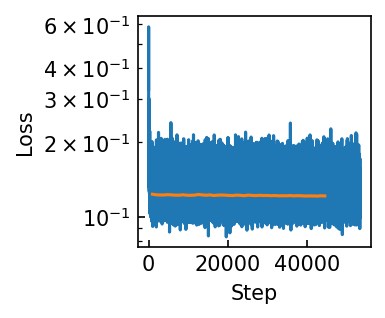

In [4]:
import torch
import json
import os
import pandas as pd
from pprint import pprint
from forecasting_dataset import SimulationDataset
from forecasting_nn import SimulationForecasting
from pprint import pprint

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_path = 'models/SimulationForecasting_0'
model_path = 'models/sigma10/SimulationForecasting_sigma10_0'

# Get validation set simulation
with open(f'{model_path}_args.txt', 'r') as f:
    info = json.load(f)
pprint(info)
sigma = info.get('sigma', 0)
val_set_size = len(info['val_folder']) * 193 / 2

folder = info['val_folder'][0]
print(f'Predicting using validation folder {os.path.basename(folder)}')
ds = SimulationDataset(folder, seq_len=25, sigma=sigma)

# Load model
info = torch.load(f'{model_path}.ckpt', map_location='cpu')
info["val_loss"] = np.array(info["val_loss"]) / val_set_size
print(f'Model reached train loss of {np.min(info["train_loss"])} and val loss of {np.min(info["val_loss"])}')
model = SimulationForecasting(smooth=sigma > 0).to(device)
model.load_state_dict(info['state_dict'])
model.eval()
print('Loaded state dict from file')

val_step = np.arange(1, len(info["val_loss"]) + 1) * val_set_size
print(len(val_step), 'Epochs', info["val_loss"])

fig, ax = plt.subplots(1, 1, dpi=150, figsize=(2, 2))
ax.plot(info["train_loss"])
ax.plot(val_step, info["val_loss"])
ax.tick_params(which='both', direction='in')
ax.set(xlabel='Step', ylabel='Loss', yscale='log')#, ylim=[3e-1, 1e0])

In [5]:
sample = ds[0]
with torch.no_grad():
    phi1 = model.simulate(sample['phi'][0:1].to(device), ds.seq_len)[0].detach().cpu().numpy().squeeze()

if sigma > 0:
    preds = phi1
else: # Sample from probability distribution returned by NN
    logits = 0.5 * (1 + phi1)
    randoms = np.random.uniform(size=phi1.shape)
    preds = np.zeros_like(phi1)
    preds[randoms < logits] = 1
    preds[randoms >= logits] = -1

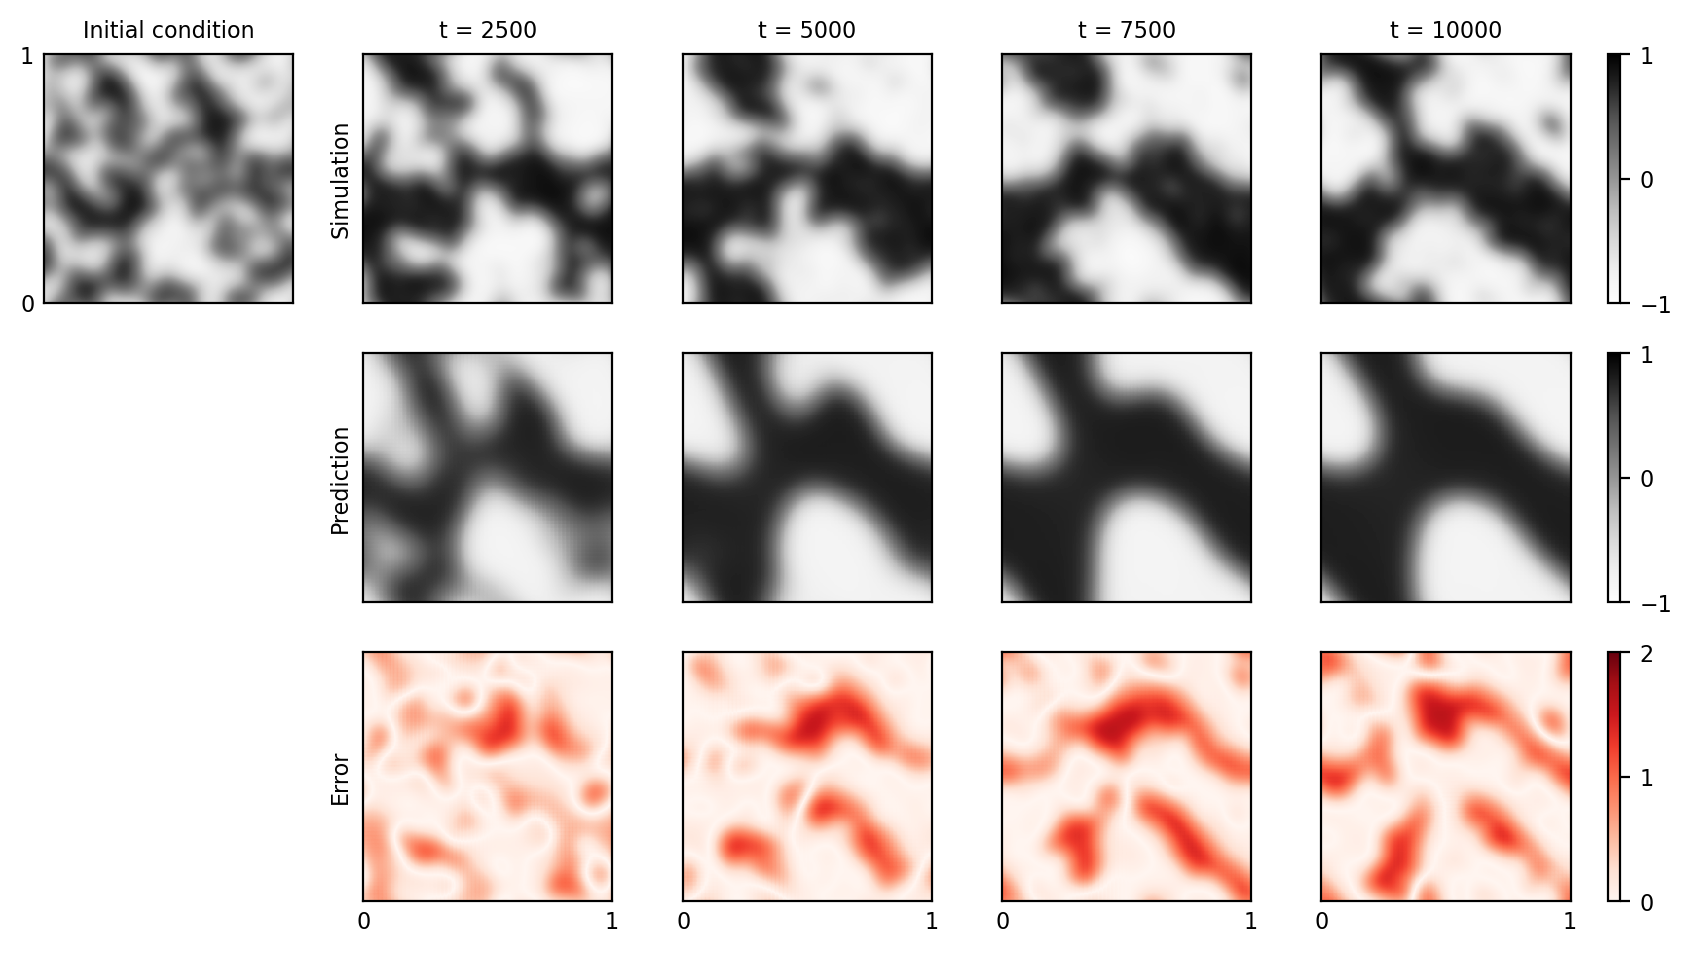

In [7]:
plt.rcParams['font.size'] = 8
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8

fig, ax = plt.subplots(3, 5, figsize=(12, 5.5), dpi=200, sharex=True, sharey=True)
dt = 5
kwargs = dict(cmap='Greys', vmin=-1, vmax=1)
for i in range(5):
    im0 = ax[0,i].pcolormesh(sample['x'], sample['y'], sample['phi'][i*dt].squeeze(), **kwargs)
    if i == 0:
        continue
    im1 = ax[1,i].pcolormesh(sample['x'], sample['y'], preds[i*dt] , **kwargs)

    err = np.abs(preds[i*dt] - sample['phi'][i*dt].squeeze().numpy())
    im2 = ax[2,i].pcolormesh(sample['x'], sample['y'], err, cmap='Reds', vmin=0, vmax=2)
    
    ax[0,i].set_title(f't = {i*dt*500}')
plt.colorbar(im0, ax=ax[0,:], pad=0.02, ticks=[-1,0,1])
plt.colorbar(im1, ax=ax[1,:], pad=0.02, ticks=[-1,0,1])
plt.colorbar(im2, ax=ax[2,:], pad=0.02, ticks=[0,1,2])

ax[0,0].set_title('Initial condition')
ax[1,0].axis('off')
ax[2,0].axis('off')

for a in ax.flatten():
    a.set(xticks=[0, 1], yticks=[0, 1], aspect='equal')
    a.tick_params(which='both', length=0)

ax[0,1].set_ylabel('Simulation')
ax[1,1].set_ylabel('Prediction')
ax[2,1].set_ylabel('Error')

fig.savefig('Figures/sample_prediction.png', dpi=300, bbox_inches='tight')